# New York vs San Francisco dataset

The group R2D3 (Stephanie Yee of StickFix and Tony Chu of Noodle.ai) have made available a [small dataset](./ny_sf_apt.csv) on housing attributes in New York and San Francisco. Unfortunately I was not able to find a corresponding dataset for Chicago. We are going to look at this dataset in the context of Logistic Regression.

## Overview of our problem

#### Goals:
* To classify houses as either belonging to NY or SF (i.e. binary classification)
* Understand how logistic regression works

#### What Logistic Regression gives us:
* A probability of a house being in SF or NY. This is called a _soft classification_.
* A classification of whether or not a house is in NY or SF by setting a cutoff on the probability. By default, this cutoff is the highest probability outcome (i.e. the class that has probabiltiy > 50%). This is called a _hard classification_.
* Coefficients, which we can use to help us interpret which features are most important to the classification (provided we have scaled them first)

#### Initial approach:
* Use one feature to make prediction (to help understand LR)
* Use two features and find decision surfaces
* Use all the features (at the expense of visualization)

In [106]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


Now import the (pre-cleaned) dataset:

In [102]:
df_housing = pd.read_csv('./ny_sf_apt.csv')
df_housing.head()

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10


Our goal is to predict whether or not the house is `in_sf` or not (if it is not in SF, it is in NY). Before going any further, let's do our test-train split:

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df_housing.iloc[:, 1:], df_housing.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

In [104]:
# Ok, which feature looks promising? We are going to restrict ourselves to one for right now
train_df = X_train.copy()
train_df['in_sf'] = y_train

train_df['location'] = train_df['in_sf'].apply(lambda x: (x and 'SF') or 'NY')
train_df.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,in_sf,location
377,3.0,2.0,2395000,1929,2323,1031,73,1,SF
124,0.0,1.0,349000,1960,400,873,13,0,NY
419,4.0,3.0,3420000,1926,5113,669,98,1,SF
417,6.0,3.5,995000,2001,3080,323,55,1,SF
172,2.0,2.0,1599000,1973,1400,1142,10,0,NY


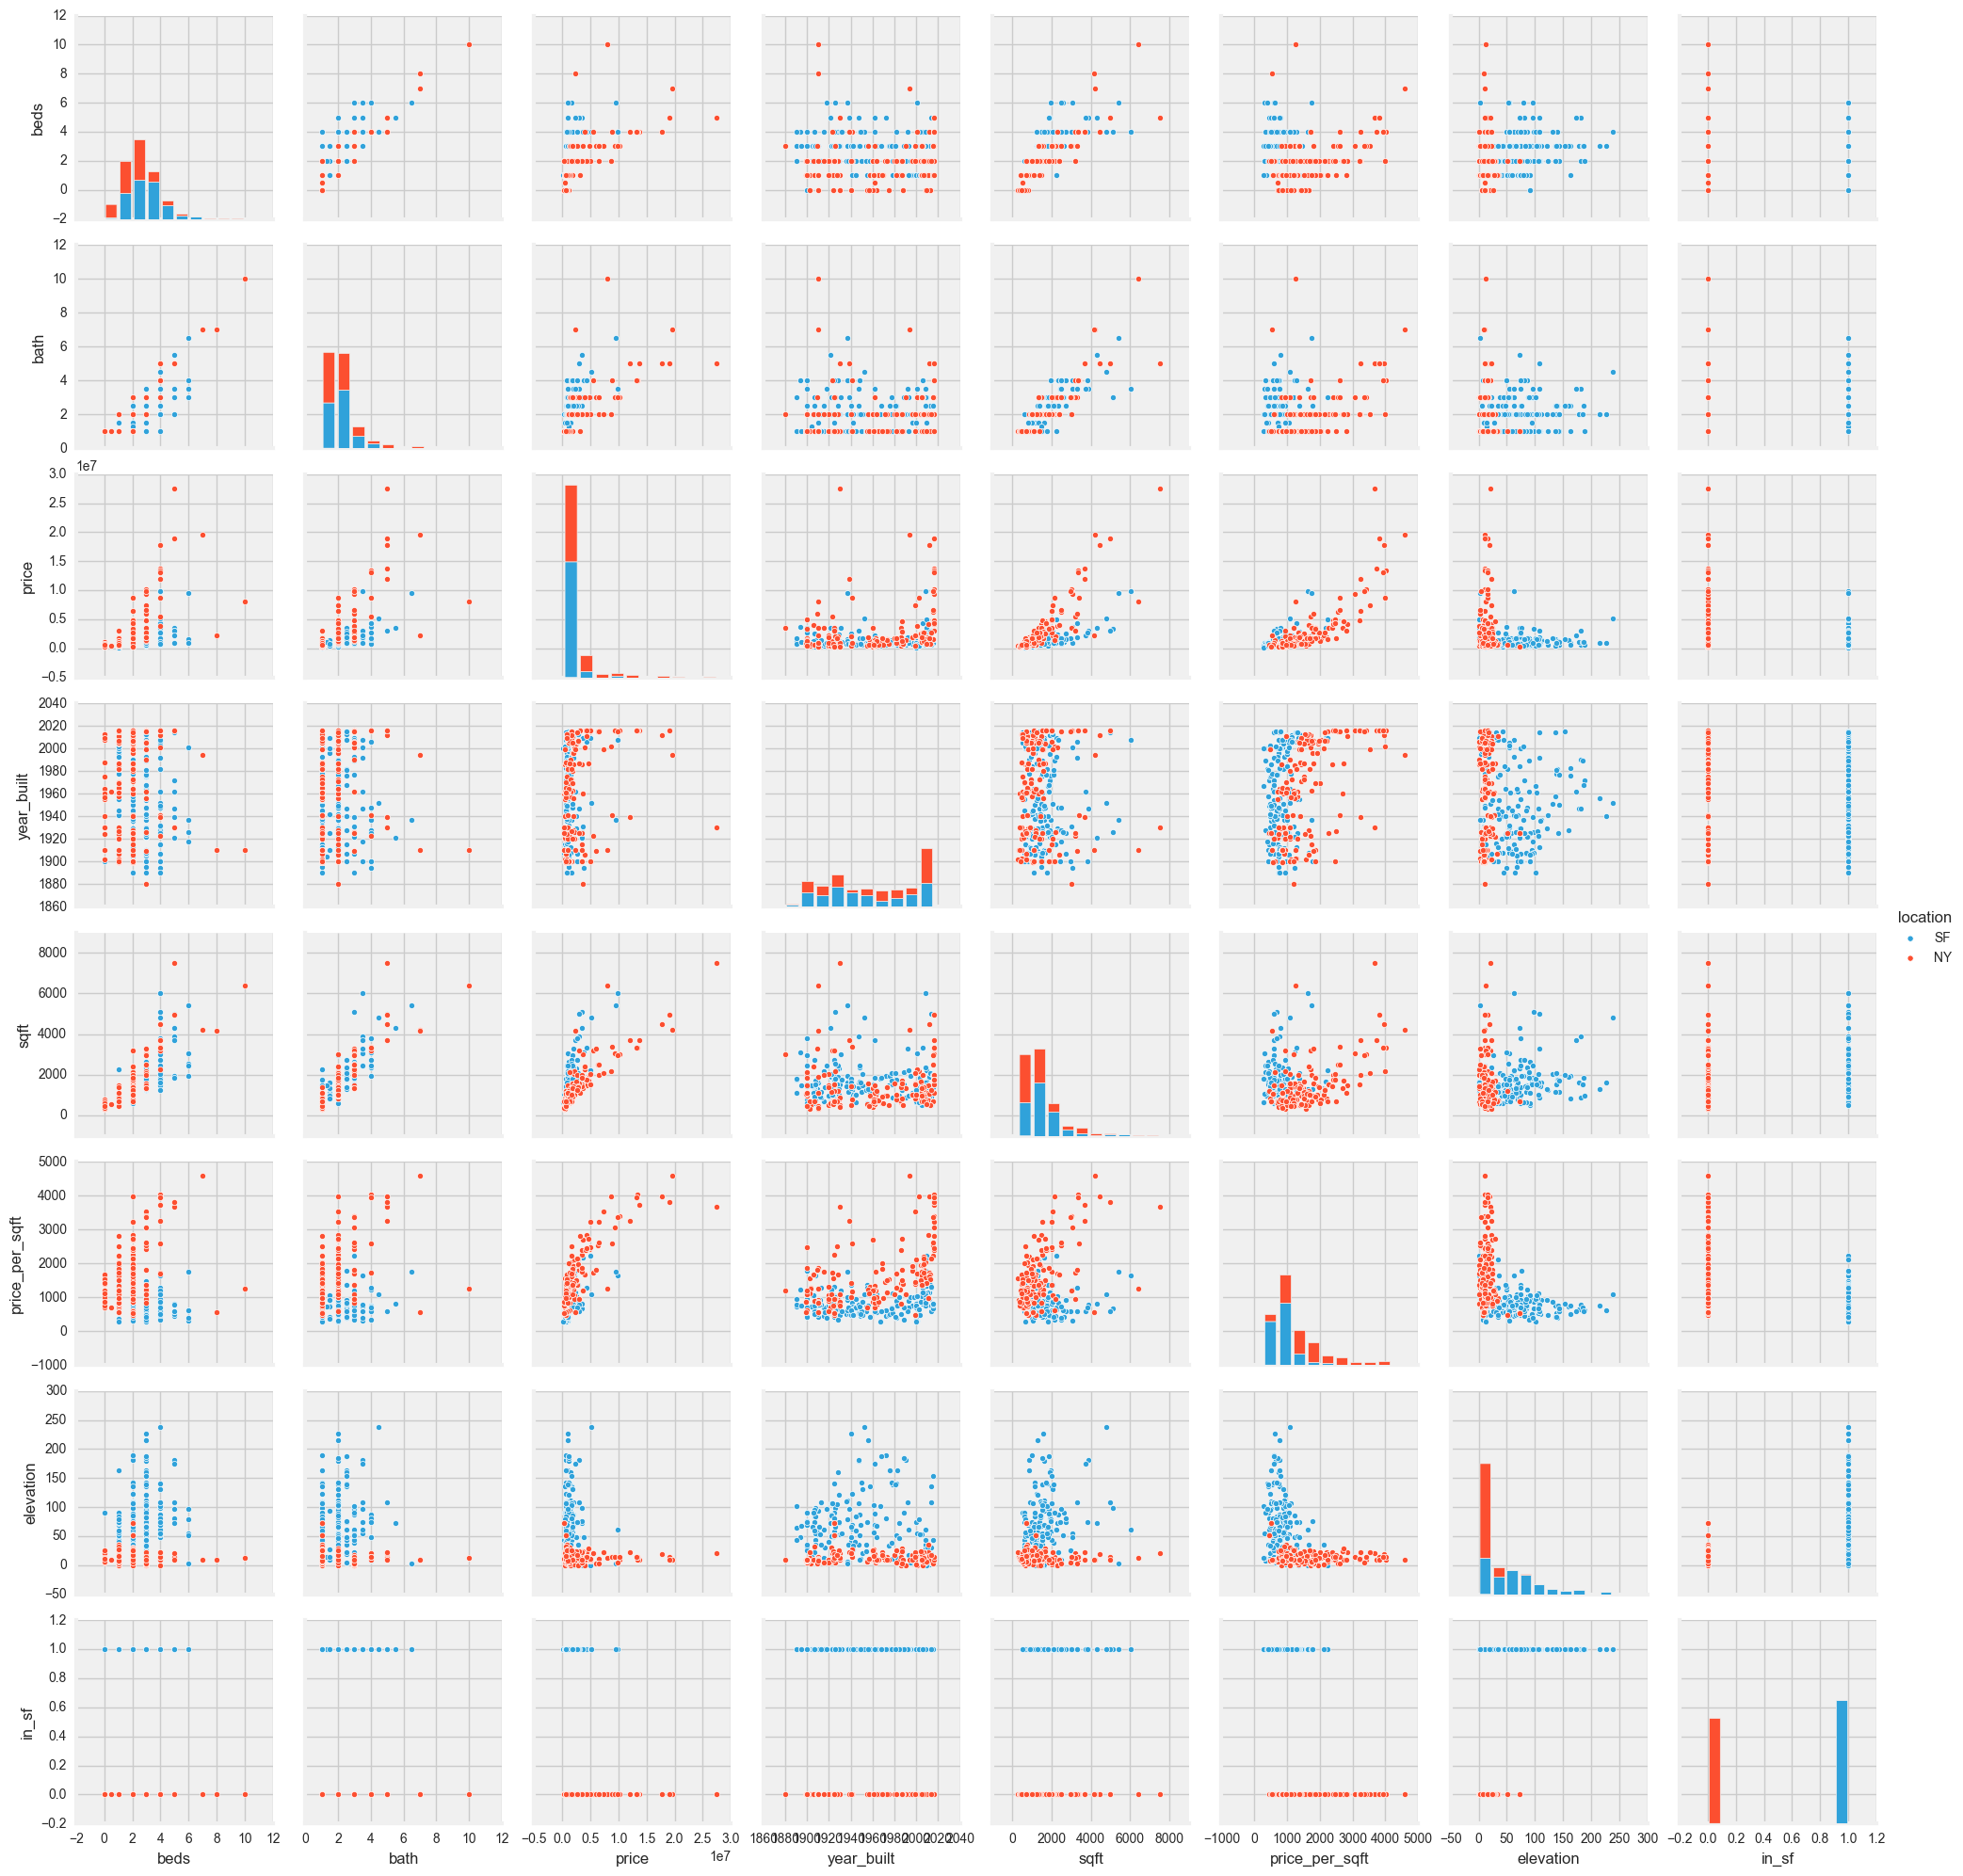

In [105]:
# We want to pick one feature to start that separates the two cases. Look down the diagonal to find an example 
# of a feature that well separates the data
sns.pairplot(train_df, hue='location')

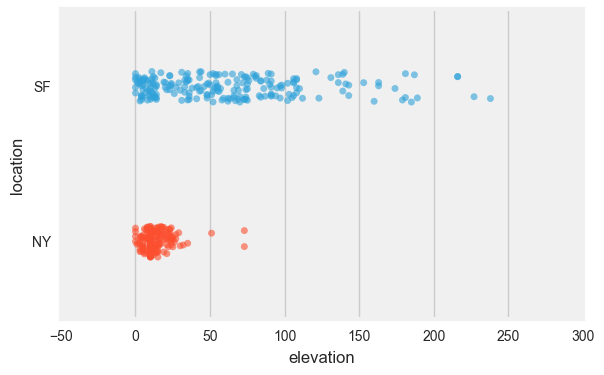

In [111]:


sns.stripplot(x='elevation',y='location', jitter=True,data=train_df,alpha=0.6);

## Enter logistic regression

Because there is only one feature (elevation) that we are looking at right now, applying the standard scaler is superflous. To keep our results interpretable, we will stay with the unscaled elevation as a feature.

In [112]:
lm1 = LogisticRegression(C=1000)
lm1.fit(X_train[['elevation']], y_train)
# Note, can also do lm1.fit(train_df[['elevation']], train_df['in_sf'])

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [113]:
lm1.score(X_train[['elevation']], y_train)

0.80407124681933839

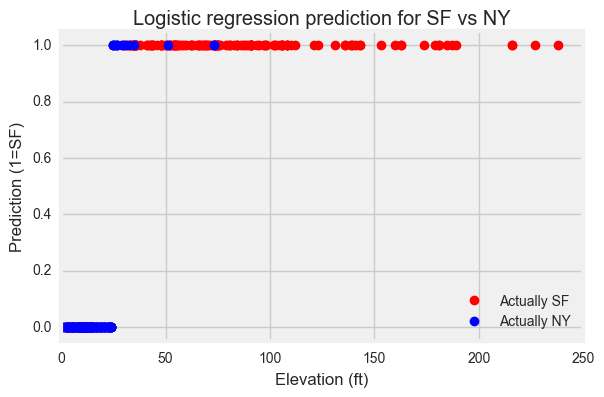

In [114]:
# Let's look at what lm1 did
feature = train_df[['elevation']].values
prediction_hard = lm1.predict(feature)

sf_mask = (train_df['location'] == 'SF').values

plt.plot(feature[sf_mask], prediction_hard[sf_mask], 'ro', label='Actually SF')
plt.plot(feature[~sf_mask], prediction_hard[~sf_mask], 'bo', label='Actually NY')
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prediction (1=SF)')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

The logistic regression has basically made a hard cutoff around 25 ft: lower than that, the prediction is you are in NY. Higher than that, the model predicts you are in SF. This is called a _hard cutoff_. 

Behind the scenes, logistic regression produces probabilities, and choses the most likely one as "the" prediction. We can also look at the model's probability of assigning a point to either SF or NY:

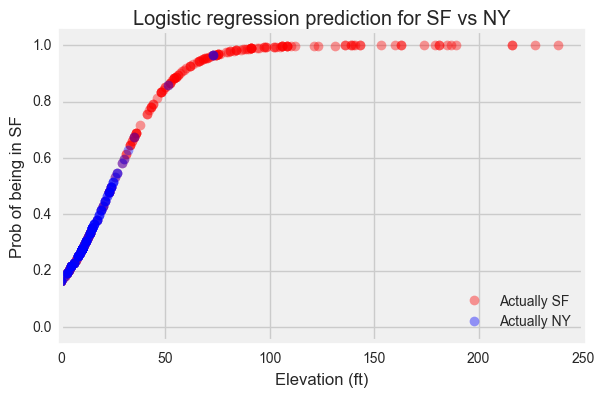

In [122]:
# This is the same model
prediction_soft = lm1.predict_proba(feature)[:, 1]

plt.plot(feature[sf_mask], prediction_soft[sf_mask], 'ro', label='Actually SF',alpha=0.4)
plt.plot(feature[~sf_mask], prediction_soft[~sf_mask], 'bo', label='Actually NY',alpha=0.4)
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prob of being in SF')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

This is called a _soft classification_, because we don't just get access to what the model is thinks is the most likely outcome, but we also get to know how likely it thinks the prediction is.

In [116]:
# Look at the coefficient and intercept of the model:
lm1.coef_, lm1.intercept_

(array([[ 0.06754]]), array([-1.62961593]))

The 50% probability is reached when $\beta \cdot \vec{x} = 0$, i.e. when $\beta_1 x_1 + \beta_0 1 = 0$. Solving this, we have
$$0.06754*elevation_{crit} - 1.62961593 = 0 \Rightarrow elevation_{crit} = \frac{1.62961593}{0.06754} \approx 24.1$$
i.e. the actual cutoff is 24.1 ft, which is close to the 25 ft we guessed by reading the graph. 

## Error type

What types of errors is this model making? From the graph, it looks like we are getting almost all the SF apartments right, and that our errors are coming from classifying some NY houses as SF houses. We are going to use the hard predictions to check with `confusion_matrix`

In [123]:
confusion_matrix(y_train, prediction_hard)

array([[168,  13],
       [ 64, 148]])

i.e. we get 

| | predict NY (0) | predict SF (1)|
|---|---|---|
| **is NY (0)** | 168 | 13|
| **is SF (1)** | 64 | 148 |

i.e. my impression from the graph is **wrong** -- the overlay of points obscures the fact we only made 13 mistakes with NY apartments, but made 64 mistakes with SF apartments. We plotted SF first, so NY can cover SF. Still, we should check and make sure we understand this:

In [128]:
# Out of those in SF, how many were predicted to be NY?
sum(prediction_hard[sf_mask] == 0)

64

Our plotting order mattered and mislead us (or at least, mislead me!)

### Cheating

For the purposes of demonstration, what would happen if we 

- throw out all SF apartments that have elevations less than 24 ft AND
- throw out all NY apartments that have elevations greater than 24 ft

from our training set? This shouldn't change the decision point much .... so what will it change?

In [94]:
# This is to explore a model
# This is NOT legitimate data science!
keep_sf_mask = ((train_df['location'] == 'SF') & (train_df['elevation'] > 24))
keep_ny_mask = ((train_df['location'] == 'NY') & (train_df['elevation'] < 24))
cheat_df = train_df[keep_sf_mask | keep_ny_mask]

In [95]:
lm2 = LogisticRegression(C=1000, max_iter=500)
lm2.fit(cheat_df[['elevation']], cheat_df['in_sf'])

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

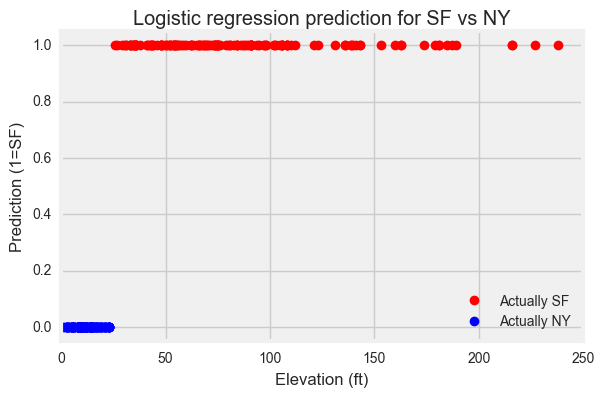

In [96]:
# Plot the 'hard' classifier. What do we expect to happen?
feature = cheat_df[['elevation']].values
prediction_hard = lm1.predict(feature)

sf_mask = (cheat_df['location'] == 'SF').values

plt.plot(feature[sf_mask], prediction_hard[sf_mask], 'ro', label='Actually SF')
plt.plot(feature[~sf_mask], prediction_hard[~sf_mask], 'bo', label='Actually NY')
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prediction (1=SF)')
plt.title('Logistic regression prediction for SF vs NY')
plt.legend(loc='lower right');

In [97]:
# Look at the coefficients:
lm2.coef_, lm2.intercept_

(array([[ 0.80323716]]), array([-20.53993742]))

Even though the decision point (23.9 ft) stayed close to the same, the coefficients and the intercept changed drastically! We still have
$$elevation_{crit} = \frac{20.53993742}{0.80323716} \approx 25.6$$

The difference is hard to see in the hard classification, but easy to spot in the simple classifier:

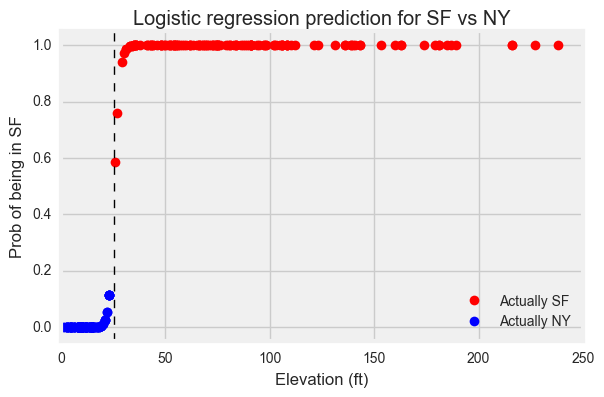

In [98]:
# This is the same model
prediction_soft = lm2.predict_proba(feature)[:, 1]

plt.plot(feature[sf_mask], prediction_soft[sf_mask], 'ro', label='Actually SF')
plt.plot(feature[~sf_mask], prediction_soft[~sf_mask], 'bo', label='Actually NY')
plt.ylim(-0.05, 1.05)
plt.xlabel('Elevation (ft)')
plt.ylabel('Prob of being in SF')
plt.title('Logistic regression prediction for SF vs NY')
plt.gca().axvline(25.6,c='k',ls='--',lw=1)
plt.legend(loc='lower right');

Even though the decision point didn't move very much, the model got a lot more certain about the predictions it did make! 

**Logistic regression doesn't maximize accuracy**

Instead, logistic regression has a cost function (in the binary classification problem) of
$$J_{\text{model}}(\beta) = -\frac{1}{m}\left(\sum_{i=1}^m y_i \ln p_i + (1-y_i) \ln (1-p_i)\right), \quad\quad p_i\text{ function of $\beta$}$$

This is called the cross-entropy. Here $y_i \in \{0,1\}$, so we can tell:
* when $y_i = 1$ (i.e. the house is actually in SF), the contribution is $-\ln p_i$. The closer $p_i$ is to 1, the smaller the cost. If $p_i = 0$ (that is, we claimed it was impossible for this house to be in SF) then we incur an infinite penalty.
* when $y_i = 0$ (i.e. the house is actually in NY), the contribution is $-\ln(1-p_i)$. The closer $p_i$ is to 0, the smaller the penalty. If we claimed $p_i = 1$ (i.e. this house in NY *must* be in SF) then we incur an infinite penalty.

The effect is that we are trying to get the model to optimize the probabilities by giving small cost to those it gets right with high confidence, a medium cost to those it 'waffles' on (i.e. doesn't commit one way or the other), and a high cost to those that it predicts with high confidence but gets wrong.

## That "C" parameter

In Linear Regression, we had an $\alpha$ parameter that controlled regularization:
$$J_{\text{linear}} = J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regression}} = \alpha \sum_{i\neq 0} |\beta_i|^q$$
where $q = 1$ (Lasso) or $q=2$ (Ridge). If $\alpha = 0$ we were effectively turning off regularization. The model cost was generally MAE or MSE.


In Logistic Regression, we have a $C$ parameter that controls the amount of regularization. We have
$$J_{\text{linear}} = C J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regression}} = \frac{1}{2}\sum_{i\neq 0} |\beta_i|^2 \text{ or } \sum_{i\neq 0} |\beta_i| $$
i.e. the regularization term is always present, and setting $C=0$ turns the model part off (i.e. it doesn't matter how much you miss the points by). So for logistic regression, high C means "lots of model importance, so regularization's effect is small" whereas low C means "model importance is small, so regularization effect is large". 

I don't know why it is done this way!

In [99]:
## Exercise
# Using train_df, make a simple model only using the feature price_per_sqft
train_df.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,in_sf,location
377,3.0,2.0,2395000,1929,2323,1031,73,1,SF
124,0.0,1.0,349000,1960,400,873,13,0,NY
419,4.0,3.0,3420000,1926,5113,669,98,1,SF
417,6.0,3.5,995000,2001,3080,323,55,1,SF
172,2.0,2.0,1599000,1973,1400,1142,10,0,NY
